## Integration

We are interested in computing numerically the integrals of general functions, using the __interpolatory quadrature rules__

$$
\int_{a}^{b} f(x) \, dx \sim \int_{a}^{b} \sum_{i=0}^{n-1} f(q_i) l_i (x) \, dx  = \sum_{i=0}^{n-1} f(q_i) \int_{a}^{b} l_i(x) \, dx = \sum_{i=0}^{n-1} f(q_i) w_i 
$$


where $l_i(x)$ are the Lagrange basis functions associated to the interpolation points $\{q_i\}_{i=0}^{n-1}$:


$$
l_i(x) := \prod_{j=0, j\neq i}^{n-1} \frac{(x-q_j)}{(q_i -q_j)}
$$


and the weights $w_i$ are defined as


$$
w_i = \int_{a}^{b} l_i (x) \, dx 
$$

### Constructing Lagrange basis functions
The first thing we should do is construct the Lagrange basis functions, which we will use to perform the integration. This is done as follows:

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
# set linear mesh for function evaluation
N = 101
x = linspace(0,1,N)

In [3]:
# define function to compute the i-th Lagrange basis polynomial
def lagrange(x,q,i):
    assert i < len(q)
    li = ones_like(x)
    for j in range(len(q)):
        if j != i:
            li = li*(x-q[j])/(q[i]-q[j])
    return li

In [4]:
# alternatively, the for cycle can be substituted with the following expression
# prod([(x-q[j])/(q[i]-q[j]) for j in range(len(q)) if j != i])

[[<matplotlib.lines.Line2D at 0x14e666b50>],

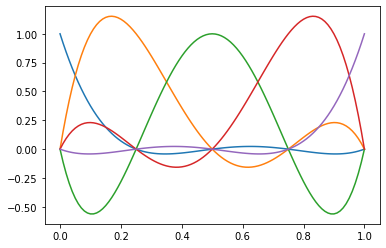

In [5]:
# setting interpolation points and plotting the Lagrange polynomials
Nq = 5
q = linspace(0,1,Nq)
[plot(x, lagrange(x,q,i)) for i in range(5)]

### Integrating the Lagrange basis functions
Now that we have explicitly constructed our functions, we need to understand how we can integrate them. To do this, the first step is to recall that the Lagrange functions are given by


$$ 
l_i(x) = V^{ij} v_j(x)
$$


where $\{v_j(x)\}_{j=0}^{n-1}$ are the monomial basis functions ($v_j(x) = x^j$), and $V^{ij}$ is the inverse matrix of $V_{ij} = v_j(q_i)$.

Now we can see that the rows of $V^{ij}$ correspond to the vectors of coefficients representing $l_i(x)$ in terms of monomials, thus we can use this expression to perform the integration.

In [6]:
# define the monomial basis
def monomial(x, i):
    return x**i

In [7]:
# define the V_{ij} matrix of monomial coefficients
V = array([monomial(q,i) for i in range(Nq)]).T

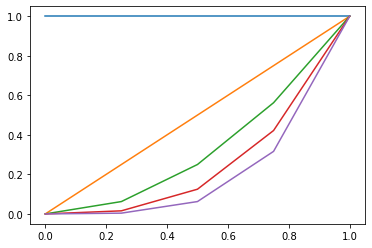

In [8]:
# plot the monomial functions (approximate)
plot(q,V)

In [9]:
# compute V^{ij} as inverse of V_{ij}
Vinv = linalg.inv(V)

To easily recover the $l_i$ function exaluated on x we now define a matrix $M$ such that

$$
M_{\alpha i} := v_{i}(x_{\alpha}) = x_{\alpha}^{i}
$$

then we can compute $l_i$ _evaluated in the specific point $x_{\alpha}$_ using the matrix

$$
L_{\alpha j} := M_{\alpha i} V^{ij} = l_j (x_\alpha)
$$

In [10]:
# computing the above matrix
M = array([monomial(x,i) for i in range(Nq)]).T

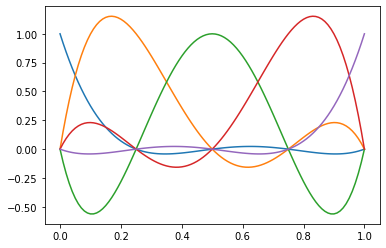

In [11]:
# plotting Lagrange functions again
L = M.dot(Vinv)
plot(x, L)

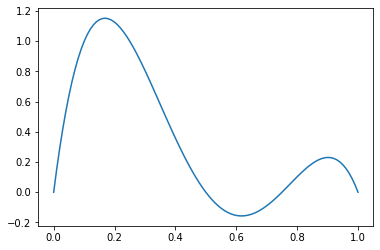

In [12]:
# we can select a single lagrange function (e.g. the first) by computing 
# the dot product of M with the corresponding column of V^{ij}
plot(x, M.dot(Vinv[:,1]))

In [13]:
# the columns of Vinv are polynomials (vectors of coefficients) of order Nq
Vinv[:,1]

array([  0.        ,  16.        , -69.33333333,  96.        ,
       -42.66666667])

Now that we have the monomial coefficients, we just need to compute the integral of the monomials to have the integral of the Lagrange basis function:

$$
\int_{a}^{b} dx \, l_i(x) = V^{ij} \int_{a}^{b}dx \, v_j(x)\, dx  = V^{ij} \int_{a}^{b} dx \, x^j = V^{ij} \left.\frac{x^{j+1}}{j+1}\right|_{a}^{b}
$$


To do this we define the vector 

$$
\{W_i\}_{i=0}^{n_1} := \left\{ \int_{a}^{b} dx \, x^i \right\}_{i=0}^{n-1} 
$$

then we the integral of the Lagrange basis function can be computed as

$$
\int_{a}^{b} dx \, l_i(x) = V^{ij} W_j
$$



In [14]:
# compute integral of monomial
def integral_of_monomial(a,b,i):
    assert i >= 0
    return (b**(i+1)-a**(i+1))/(i+1)

In [15]:
# define vector W
W = array([integral_of_monomial(0,1,i) for i in range(Nq)])

In [16]:
# compute the integrals for each of the Lagrange functions on 
# selected nodes, i.e. the weights for our quadrature rule
w = W.dot(Vinv)

In [17]:
# this is a vector, each element is the integral of the l_i
w.shape

(5,)

### Integrating our function
Finally, we can compute the integral of our function using the quadrature rule as

$$
\int_{a}^{b} dx \, f(x) \sim \sum_{i=0}^{n-1} f(q_i) w_i
$$

In [18]:
# programmatically, we define a function that computes the weights
def weights_of_quadrature_rule(q,a,b):
    Nq = len(q)
    V = array([q**i for i in range(Nq)]).T
    Vinv = linalg.inv(V)
    W = array([integral_of_monomial(a,b,i) for i in range(Nq)])
    w = W.dot(Vinv)
    return w

In [19]:
w = weights_of_quadrature_rule(q,0,1)

In [20]:
w

array([0.07777778, 0.35555556, 0.13333333, 0.35555556, 0.07777778])

To check that our procedure works we can test it on polynomials of degree lower than $n$, in fact in these cases we have 

$$
\int_{a}^{b} dx \, p \color{red}{=} \sum_{i=0}^{n-1} p(q_i)w_i \qquad \forall p \in P^k(a,b), \; k<=n-1
$$

In [21]:
# testing on simple monomials x^i, even for 
array([(q**i).dot(w) for i in range(2*Nq)])

array([1.        , 0.5       , 0.33333333, 0.25      , 0.2       ,
       0.16666667, 0.14322917, 0.12630208, 0.11389974, 0.10473633])

In [22]:
# define function that computes error of intrerpolation quadrature
def error_on_monomial(q,w,a,b,i):
    exact = integral_of_monomial(a,b,i)
    computed = (q**i).dot(w)
    return abs(exact-computed)

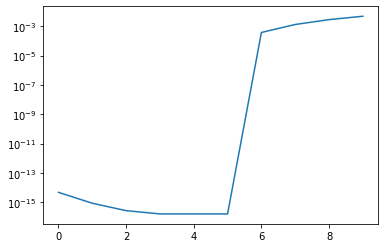

In [23]:
# compute errors on monomials and plot (log scale)
error = array([error_on_monomial(q,w,0,1,i) for i in range(2*Nq)])
semilogy(error)

Note on the result: from the plot we can see that up to $n$=Nq (and not $n-1$) we have almost zero error, i.e. the integral computed with quadrature has the same value as the exact integral (the small difference from zero is due to machine precision limitations).
This fact that even for $n$ the formula still holds is due to the fact that our interpolation points are symmetric, if not it would have stopped at $n-1$.
From $n+1$ and onward, the error explodes, and the quadrature formula is not a good approximation anymore.

### Gauss quadrature rule
Now we have proved that our interpolation quadrature technique works, and we can improve on it. To do that we proceed to build Gauss quadrature formula, which is exact up to $2*n-1$ (instead of $n-1$ or $n$ as the one before).

In [24]:
# compute quadrature weights and error with equispaced points in -1,1
q = linspace(-1,1,Nq)
w = weights_of_quadrature_rule(q,-1,1)
error = array([error_on_monomial(q,w,-1,1,i) for i in range(2*Nq)])

In [25]:
# compute quadrature weights and error with Legendre points in -1,1
qg, wg = numpy.polynomial.legendre.leggauss(Nq)
errorg = array([error_on_monomial(qg,wg,-1,1,i) for i in range(2*Nq+2)])

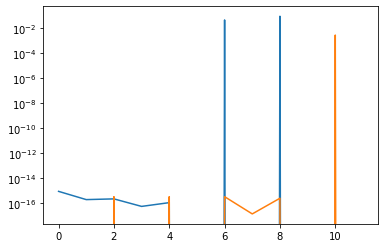

In [26]:
# plot errors to make comparison
semilogy(error)
semilogy(errorg)

As we can see, the error for gauss blows up for $k=2*n$ (=10), but for smaller values it is always close to being exact.


Now let's make the comparison on a general interval [a,b], using a test function.

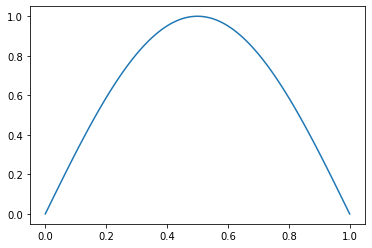

In [27]:
# define test function, for which we know the value of the integral
def myfun(x):
    return sin(pi*x)

def myint():
    return 2/pi

plot(x, myfun(x))

In [28]:
def difference_between_gauss_and_equispaced(N,a,b,myfun,myintegral):
    assert N >= 1
    errors = zeros((N-1,2))
    for Nq in range(1,N):
        
        # rescaling gauss quadrature between a and b
        qg, wg = numpy.polynomial.legendre.leggauss(Nq)
        qg = (qg+1)*(b-a)/2+a
        wg = wg/2*(b-a)

        # compute equispaced quadrature
        q = linspace(a,b,Nq)
        w = weights_of_quadrature_rule(q,a,b)
        
        # compute errors
        index = Nq-1
        errors[index, 0] = abs(myfun(q).dot(w) - myintegral())
        errors[index, 1] = abs(myfun(qg).dot(wg) - myintegral())
        
    return errors

In [29]:
errors = difference_between_gauss_and_equispaced(10, 0,1, myfun, myint)

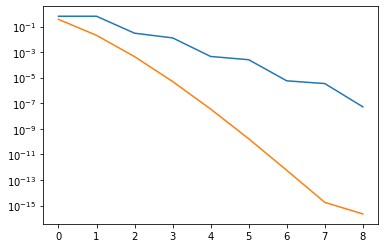

In [30]:
semilogy(errors)

In [31]:
errors

array([[6.36619772e-01, 3.63380228e-01],
       [6.36619772e-01, 2.04292639e-02],
       [3.00468943e-02, 4.42104932e-04],
       [1.28992805e-02, 5.02023783e-06],
       [4.54950190e-04, 3.51046376e-08],
       [2.53663085e-04, 1.66389569e-10],
       [5.67025661e-06, 5.69211345e-13],
       [3.45861035e-06, 1.77635684e-15],
       [5.24323818e-08, 2.22044605e-16]])

This tells us that for the test function the difference between the exact integral and the computed integral reaches machine precision in 7 / 8 steps using Gauss quadrature, while it takes a lot more for equispaced.

As a side note: we can see that our function for computing quadrature works by confronting it with the one from numpy

In [32]:
Nq = 5
q = linspace(-1,1,Nq)
q,w = numpy.polynomial.legendre.leggauss(Nq)
myw = weights_of_quadrature_rule(q,-1,1)

In [33]:
w, myw

(array([0.23692689, 0.47862867, 0.56888889, 0.47862867, 0.23692689]),
 array([0.23692689, 0.47862867, 0.56888889, 0.47862867, 0.23692689]))

#### What about Chebyshev points?
What happens if we use Chebyshev points to compute the quadrature formula? 
To see it we modify our function from before, adding the Chebyshev points

In [34]:
def difference_gauss_chebyshev_equispaced(N,a,b,myfun,myintegral):
    assert N >= 1
    errors = zeros((N-1,3))
    for Nq in range(1,N):
        
        # rescaling gauss quadrature between a and b
        qg, wg = numpy.polynomial.legendre.leggauss(Nq)
        qg = (qg+1)*(b-a)/2+a
        wg = wg/2*(b-a)
        
        # rescaling Chebyshev
        qc, wc = numpy.polynomial.chebyshev.chebgauss(Nq)
        qc = (qc+1)*(b-a)/2+a
        wc = weights_of_quadrature_rule(qc,a,b)

        # compute equispaced quadrature
        q = linspace(a,b,Nq)
        w = weights_of_quadrature_rule(q,a,b)
        
        # compute errors
        index = Nq-1
        errors[index, 0] = abs(myfun(q).dot(w) - myintegral())
        errors[index, 1] = abs(myfun(qc).dot(wc) - myintegral())
        errors[index, 2] = abs(myfun(qg).dot(wg) - myintegral())
        
    return errors

In [35]:
errors = difference_gauss_chebyshev_equispaced(10, 0,1, myfun, myint)

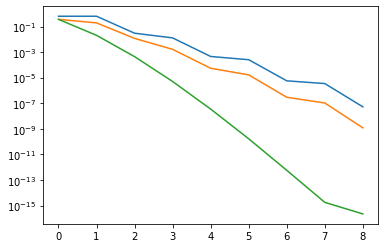

In [36]:
semilogy(errors)

We can see that using Chebyshev points to compute integration we are not getting far better results than using simple equispaced points. This is due to the fact that Chebyshev points are optimized for interpolation, not for integration.

#### What if we use a not-so-nice function?
Now we do the same thing once again, but using a function that is not smooth.

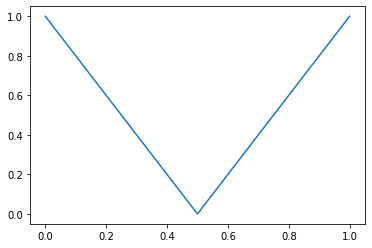

In [37]:
def absfun(x):
    return 2*abs(x-0.5)

def absint():
    return 0.5

plot(x, absfun(x))

In [38]:
errors = difference_gauss_chebyshev_equispaced(10, 0,1, absfun, absint)

([<matplotlib.lines.Line2D at 0x14ebe27f0>,
 (0.001584893192461114, 0.6309573444801932))

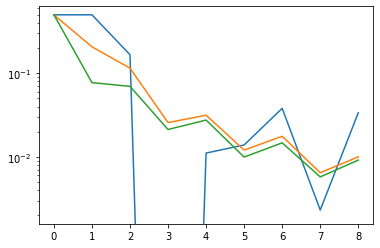

In [39]:
semilogy(errors), ylim([10**(-2.8),10**(-0.2)])

In this case we can see that the Chabyshev quadrature gets closer and closer to the Gauss quadrature. The reason is that Chebyshev is better at interpolating non -smooth functions.
Equispaced is generally worse, except for the case in which we have three points, but this is specifical for the function we have taken to make the comparison.

According to what we need to do, in particular to the regularit of the function we are dealing with, it may be better to use one or the other.

### Final considerations on integration of non-smooth functions
In general, when we have non-smooth functions, a clever way to proceed is to split the interval in smaller pieces, and compute the integral over these pieces using trapezoidal rule, or Monte Carlo. Let's see how it behaves wrt to the others.

In [40]:
def difference_between_formulas(N,a,b,myfun,myintegral):
    assert N >= 1
    errors = zeros((N-1,4))
    for Nq in range(1,N):
        
        # rescaling gauss quadrature between a and b
        qg, wg = numpy.polynomial.legendre.leggauss(Nq)
        qg = (qg+1)*(b-a)/2+a
        wg = wg/2*(b-a)
        
        # rescaling Chebyshev
        qc, wc = numpy.polynomial.chebyshev.chebgauss(Nq)
        qc = (qc+1)*(b-a)/2+a
        wc = weights_of_quadrature_rule(qc,a,b)

        # compute equispaced quadrature
        q = linspace(a,b,Nq)
        w = weights_of_quadrature_rule(q,a,b)
        
        # "averaged" midpoint or iterated trapezoidal
        wa = ones_like(q)/(len(q))*(b-a)
        
        # compute errors
        index = Nq-1
        errors[index, 0] = abs(myfun(q).dot(w) - myintegral())
        errors[index, 1] = abs(myfun(qc).dot(wc) - myintegral())
        errors[index, 2] = abs(myfun(qg).dot(wg) - myintegral())
        errors[index, 3] = abs(myfun(q).dot(wa) - myintegral())
        
    return errors

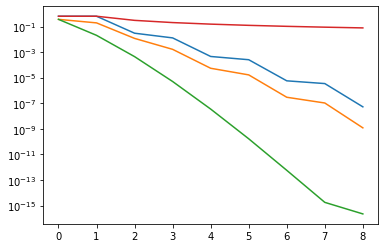

In [41]:
# for smooth functions the last is horrible
errors = difference_between_formulas(10, 0,1, myfun, myint)
semilogy(errors)

([<matplotlib.lines.Line2D at 0x14ee5e220>,
 (0.001584893192461114, 0.6309573444801932))

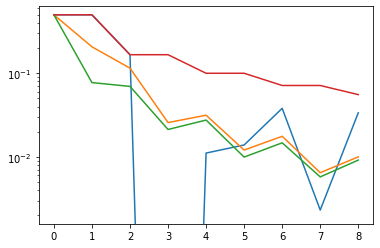

In [42]:
# for non-smooth functions it behaves a lot better (actually, the other are worse)
errors = difference_between_formulas(10, 0,1, absfun, absint)
semilogy(errors), ylim([10**(-2.8),10**(-0.2)])

NOTE: when using large n (Nq) it is very likely that these calculations won't make sense, since there may be problems with Vinv and its well-posedness (small condition numbers).